In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import networkx as nx

In [47]:
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import copy

class Segment:
    def __init__(self, start_point, parent_segment=None):
        self.start_point = start_point  # Starting position (tuple)
        self.end_point = start_point    # Updated as the tip cell moves
        self.parent_segment = parent_segment  # Parent Segment object
        self.child_segments = []  # List of child Segment objects (branches)
        self.length = 0.0  # Total length of the segment
        self.path = [start_point]  # List of positions forming the segment path
        self.anastomosed = False  # Flag to indicate if the segment has anastomosed
        self.anastomosed_with = None  # Segment object it anastomosed with

class angio_abm:
    def __init__(self,
                 IC='linear',
                 rho=0.1,
                 t_final=500.0,
                 chi=2.0,
                 chemo_rate='const',
                 psi=0.1):

        # Parameters
        self.D = .00035
        self.alpha = 0.6
        self.chi = chi
        self.rho = rho
        self.beta = 0.05
        self.gamma = 0.1
        self.eta = 0.1
        self.psi = psi

        self.nb_const = 2.5
        self.chemo_rate = chemo_rate

        # Grids
        self.eps1 = 0.45
        self.eps2 = 0.45
        self.k = 0.75
        self.nu = (np.sqrt(5) - 0.1)/(np.sqrt(5)-1)

        self.xn = 201
        self.yn = 201
        self.x = np.linspace(0, 1, self.xn)
        self.y = np.linspace(0, 1, self.yn)
        self.IC = IC
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]

        self.dt = 0.01
        self.t_final = t_final
        self.time_grid = np.arange(0, self.t_final, self.dt)

        self.write_folder = 'results/'
        self.file_name = f'IC_{self.IC}_rho_{round(self.rho, 2)}_chi_{round(self.chi, 2)}'

        if not os.path.isdir(self.write_folder):
            os.mkdir(self.write_folder)

        # Initialize sprouts
        self.cell_locs = [[0, .1], [0, .2], [0, .3], [0, .4], [0, .5],
                          [0, .6], [0, .7], [0, .8], [0, .9]]
        self.sprouts = []  # List of lists of positions for each sprout
        self.sprout_ages = []  # Ages of sprouts
        self.branches = 0  # Total number of branches

        # Time-dependent data
        self.sprouts_time = []
        self.branches_time = []
        self.active_tips = []

        # Initialize vessel network matrix
        self.N = np.zeros((self.xn, self.yn))

        # Initialize segments and mappings
        self.segments = []  # List of all segments
        self.current_segments = []  # Current segment for each sprout
        self.position_to_segment = {}  # Mapping from positions to segments

    def IC_generate(self):
        '''
        Sets the initial conditions for n , C, and F.
        '''
        self.Y, self.X = np.meshgrid(self.y, self.x)

        # TAF
        if self.IC == 'tumor':
            # Equation 10 & 11 in Anderson-Chaplain
            r = np.sqrt((self.X-1)**2 + (self.Y-0.5)**2)
            self.C = (self.nu - r)**2/(self.nu-0.1) / 1.68
            self.C[r <= 0.1] = 1
        elif self.IC == 'linear':
            # Equation 12 in Anderson-Chaplain
            self.C = np.exp(-((1-self.X)**2)/self.eps1)

        # Fibronectin
        # Equation 13 in Anderson-Chaplain
        self.F = self.k*np.exp(-self.X**2/self.eps2)

    def chemotaxis_rate(self, C_value):
        '''
        Returns the chemotaxis rate based on the local chemoattractant concentration.
        '''
        if self.chemo_rate == 'hill':
            return self.chi / (1 + self.alpha * C_value)
        elif self.chemo_rate == 'const':
            return self.chi

    def sprout_initialize(self):
        '''
        Initializes the sprouts at the specified locations.
        '''
        for c in self.cell_locs:
            start_pos = (np.argmin(np.abs(self.x - c[0])), np.argmin(np.abs(self.y - c[1])))
            self.new_sprout([start_pos], parent_segment=None)

    def new_sprout(self, loc, parent_segment=None):
        '''
        Creates a new sprout starting at the given location.

        loc: List of starting position tuples.
        parent_segment: The parent Segment object if this is a branch.
        '''
        # Create a new Segment
        start_point = loc[0]
        new_segment = Segment(start_point=start_point, parent_segment=parent_segment)

        # Add to parent segment's child_segments if applicable
        if parent_segment is not None:
            parent_segment.child_segments.append(new_segment)

        # Add to segments list and current_segments list
        self.segments.append(new_segment)
        self.current_segments.append(new_segment)

        # Append to sprouts list and initialize age
        self.sprouts.append(loc)
        self.sprout_ages.append(0)

        # Update vessel network and position mapping
        self.N[start_point] = 1
        self.position_to_segment[start_point] = new_segment

    def move_sprouts(self):
        '''
        Updates the tip cell locations and the vessel network based on movement probabilities.
        '''
        for i, nl in enumerate(self.sprouts):
            # Skip if sprout has anastomosed
            if self.sprout_ages[i] == -1:
                continue

            # Current tip cell position
            n = nl[-1]
            segment = self.current_segments[i]

            # Sample local gradients
            C_gradx, C_gradx_dwn, C_gradx_up, C_grady, C_grady_dwn, C_grady_up = grad_est(n, self.xn, self.yn, self.C)
            F_gradx, F_gradx_dwn, F_gradx_up, F_grady, F_grady_dwn, F_grady_up = grad_est(n, self.xn, self.yn, self.F)

            # Determine indices of up/down wind based on gradients.
            n_x_up, n_x_dwn, n_y_up, n_y_dwn = chi_grad_det(n, self.xn, self.yn, C_gradx, C_grady)

            ### Move tip cells: P0 is the probability a cell stays put, P1-4 are the probabilities
            ### of moving right, left, up, and down, respectively.

            # Start with just diffusion
            P0 = 1.0 - 4.0 * self.dt / (self.dx ** 2) * self.D

            # Move right, left, up, down
            P1 = self.dt / (self.dx ** 2) * self.D
            P2 = self.dt / (self.dx ** 2) * self.D
            P3 = self.dt / (self.dx ** 2) * self.D
            P4 = self.dt / (self.dx ** 2) * self.D

            ### Incorporate chemotaxis and haptotaxis
            # Chemotaxis in x-direction
            chi = self.chemotaxis_rate(self.C[n])
            if C_gradx > 0:
                P0 -= self.dt / (self.dx ** 2) * chi * C_gradx_dwn
                P1 += self.dt / (self.dx ** 2) * chi * C_gradx_up
            elif C_gradx < 0:
                P0 += self.dt / (self.dx ** 2) * chi * C_gradx_up
                P2 -= self.dt / (self.dx ** 2) * chi * C_gradx_dwn

            # Chemotaxis in y-direction
            if C_grady > 0:
                P0 -= self.dt / (self.dx ** 2) * chi * C_grady_dwn
                P3 += self.dt / (self.dx ** 2) * chi * C_grady_up
            elif C_grady < 0:
                P0 += self.dt / (self.dx ** 2) * chi * C_grady_up
                P4 -= self.dt / (self.dx ** 2) * chi * C_grady_dwn

            # Haptotaxis in x-direction
            rho = self.rho
            if F_gradx > 0:
                P0 += rho * self.dt / (self.dx ** 2) * F_gradx_dwn
                P2 -= rho * self.dt / (self.dx ** 2) * F_gradx_up
            elif F_gradx < 0:
                P0 -= rho * self.dt / (self.dx ** 2) * F_gradx_up
                P1 += rho * self.dt / (self.dx ** 2) * F_gradx_dwn

            # Haptotaxis in y-direction
            if F_grady > 0:
                P0 += rho * self.dt / (self.dx ** 2) * F_grady_dwn
                P4 -= rho * self.dt / (self.dx ** 2) * F_grady_up
            elif F_grady < 0:
                P0 -= rho * self.dt / (self.dx ** 2) * F_grady_up
                P3 += rho * self.dt / (self.dx ** 2) * F_grady_dwn

            # Ensure probabilities are non-negative
            P0 = max(P0, 0)
            P1 = max(P1, 0)
            P2 = max(P2, 0)
            P3 = max(P3, 0)
            P4 = max(P4, 0)

            # Normalize probabilities
            total_P = P0 + P1 + P2 + P3 + P4
            if total_P == 0:
                P0 = 1.0
                P1 = P2 = P3 = P4 = 0.0
                total_P = 1.0

            P0 /= total_P
            P1 /= total_P
            P2 /= total_P
            P3 /= total_P
            P4 /= total_P

            # Determine random number
            r = np.random.uniform(0, 1)

            moved = False
            if r < P0:
                # Stay put
                nl.append(n)
            elif r < P0 + P1:
                # Move right
                if n[0] < self.xn - 1:
                    new_position = (n[0] + 1, n[1])
                    nl.append(new_position)
                    moved = True
                else:
                    nl.append(n)
            elif r < P0 + P1 + P2:
                # Move left
                if n[0] > 0:
                    new_position = (n[0] -1, n[1])
                    nl.append(new_position)
                    moved = True
                else:
                    nl.append(n)
            elif r < P0 + P1 + P2 + P3:
                # Move up
                if n[1] < self.yn - 1:
                    new_position = (n[0], n[1] +1)
                    nl.append(new_position)
                    moved = True
                else:
                    nl.append(n)
            else:
                # Move down
                if n[1] > 0:
                    new_position = (n[0], n[1] -1)
                    nl.append(new_position)
                    moved = True
                else:
                    nl.append(n)

            if moved:
                segment.path.append(new_position)
                segment.end_point = new_position

                if self.N[new_position] == 1:
                    # Anastomosis occurs
                    other_segment = self.position_to_segment.get(new_position)
                    if other_segment is not None:
                        segment.anastomosed = True
                        segment.anastomosed_with = other_segment
                        self.sprout_ages[i] = -1  # Tip cell is no longer active
                        self.current_segments[i] = None
                        self.N[new_position] = 1
                        self.position_to_segment[new_position] = segment
                        continue
                else:
                    # Update vessel network and position mapping
                    self.N[new_position] = 1
                    self.position_to_segment[new_position] = segment
            else:
                # Append current position to segment path even if not moved
                segment.path.append(nl[-1])

    def branch(self):
        '''
        Determines if tip cells should branch and creates new sprouts if needed.
        '''
        for i, nl in enumerate(self.sprouts):
            if self.sprout_ages[i] == -1:
                continue

            n = nl[-1]
            segment = self.current_segments[i]
            branch_occurred = False

            if self.sprout_ages[i] > self.psi:
                # Check for available neighboring positions
                x_range = range(max(n[0] - 1, 0), min(n[0] + 2, self.xn))
                y_range = range(max(n[1] -1, 0), min(n[1] +2, self.yn))
                neighbors = [(x, y) for x in x_range for y in y_range if self.N[(x, y)] == 0]

                if neighbors:
                    # Probability of branching
                    pb = prob_branch(self.C[n])
                    if np.random.uniform() < pb:
                        # Choose a random available neighbor
                        new_position = neighbors[np.random.choice(len(neighbors))]
                        # Create new sprout with parent segment
                        self.new_sprout([new_position], parent_segment=segment)
                        branch_occurred = True
                        self.sprout_ages[i] = 0  # Reset age after branching
                        self.branches +=1

            if not branch_occurred:
                self.sprout_ages[i] += self.dt

    def update_grids(self):
        '''
        Updates F and C based on the equations from Anderson-Chaplain.
        '''
        for nl in self.sprouts:
            n = nl[-1]
            self.F[n] = self.F[n]*(1 - self.dt*self.gamma) + self.dt*self.beta
            self.C[n] = self.C[n]*(1 - self.dt*self.eta)

    def record_bio_data(self):
        '''
        Records the number of sprouts, branches, and active tip cells over time.
        '''
        self.sprouts_time.append(len(self.sprouts))
        self.branches_time.append(self.branches)
        self.active_tips.append(sum(age != -1 for age in self.sprout_ages))

    def compute_segment_length(self, segment):
        '''
        Computes the length of a segment based on its path.
        '''
        length = 0.0
        for i in range(1, len(segment.path)):
            p1 = segment.path[i -1]
            p2 = segment.path[i]
            x1, y1 = self.x[p1[0]], self.y[p1[1]]
            x2, y2 = self.x[p2[0]], self.y[p2[1]]
            length += np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        segment.length = length
        return length

    def build_graph(self):
        '''
        Builds a graph representation of the vessel network using NetworkX.
        Nodes are positions, and edges are segments with length attributes.
        '''
        G = nx.Graph()

        # Compute lengths for all segments
        for segment in self.segments:
            self.compute_segment_length(segment)

        # Add nodes and edges to the graph
        for segment in self.segments:
            start_node = segment.start_point
            end_node = segment.end_point
            G.add_node(start_node, pos=(self.x[start_node[0]], self.y[start_node[1]]))
            G.add_node(end_node, pos=(self.x[end_node[0]], self.y[end_node[1]]))
            G.add_edge(start_node, end_node, length=segment.length)

        return G

# Supporting functions as defined in the original code
def grad_est(n, x_n, y_n, C):
    '''
    Estimates the gradient of the matrix C at point n with respect to x and y
    '''
    if n[0] == 0:
        # Leftmost boundary
        x_grad_dwn = C[(n[0]+1, n[1])] - C[(n[0], n[1])]
        x_grad_up = x_grad_dwn
        x_grad = x_grad_dwn
    elif n[0] == x_n - 1:
        # Rightmost boundary
        x_grad_dwn = C[(n[0], n[1])] - C[(n[0]-1, n[1])]
        x_grad_up = x_grad_dwn
        x_grad = x_grad_dwn
    else:
        # Interior point
        x_grad_dwn = C[(n[0], n[1])] - C[(n[0]-1, n[1])]
        x_grad_up = C[(n[0]+1, n[1])] - C[(n[0], n[1])]
        x_grad = (C[(n[0]+1, n[1])] - C[(n[0]-1, n[1])]) / 2

    if n[1] == 0:
        # Bottom boundary
        y_grad_dwn = C[(n[0], n[1]+1)] - C[(n[0], n[1])]
        y_grad_up = y_grad_dwn
        y_grad = y_grad_dwn
    elif n[1] == y_n - 1:
        # Top boundary
        y_grad_dwn = C[(n[0], n[1])] - C[(n[0], n[1]-1)]
        y_grad_up = y_grad_dwn
        y_grad = y_grad_dwn
    else:
        # Interior point
        y_grad_dwn = C[(n[0], n[1])] - C[(n[0], n[1]-1)]
        y_grad_up = C[(n[0], n[1]+1)] - C[(n[0], n[1])]
        y_grad = (C[(n[0], n[1]+1)] - C[(n[0], n[1]-1)]) / 2

    return x_grad, x_grad_dwn, x_grad_up, y_grad, y_grad_dwn, y_grad_up

def chi_grad_det(n, xn, yn, C_gradx, C_grady):
    '''
    Determines where to sample for up or downwind from the point n based on x- and y- gradients of C
    '''
    if C_gradx >= 0:
        if n[0] != xn - 1:
            n_grad_x_up = (n[0]+1, n[1])
            n_grad_x_dwn = None
        else:
            n_grad_x_up = n
            n_grad_x_dwn = None
    else:
        if n[0] != 0:
            n_grad_x_up = None
            n_grad_x_dwn = (n[0]-1, n[1])
        else:
            n_grad_x_up = None
            n_grad_x_dwn = n

    if C_grady >= 0:
        if n[1] != yn - 1:
            n_grad_y_up = (n[0], n[1]+1)
            n_grad_y_dwn = None
        else:
            n_grad_y_up = n
            n_grad_y_dwn = None
    else:
        if n[1] != 0:
            n_grad_y_up = None
            n_grad_y_dwn = (n[0], n[1]-1)
        else:
            n_grad_y_up = None
            n_grad_y_dwn = n

    return n_grad_x_up, n_grad_x_dwn, n_grad_y_up, n_grad_y_dwn

def prob_branch(C_value):
    '''
    Provides probability of a sprout branching based on the local chemoattractant gradient
    '''
    return 1.0  # You can modify this function to return different probabilities

# Simulation execution
def run_simulation():
    # Initialize simulation
    A = angio_abm()
    A.IC_generate()
    A.sprout_initialize()

    # Run the ABM until one of the sprouts reaches x = 0.95 or time exceeds t_final
    max_x = 0
    j = 0
    while max_x < 0.95:
        A.move_sprouts()
        A.update_grids()
        A.branch()
        A.record_bio_data()
        max_x = np.max(A.X[A.N == 1])
        j += 1
        if A.dt * j > A.t_final:
            break

    # Build the graph representation of the vessel network
    G = A.build_graph()

    # Now G is a NetworkX graph with nodes and edges labeled by segment lengths
    return G, A




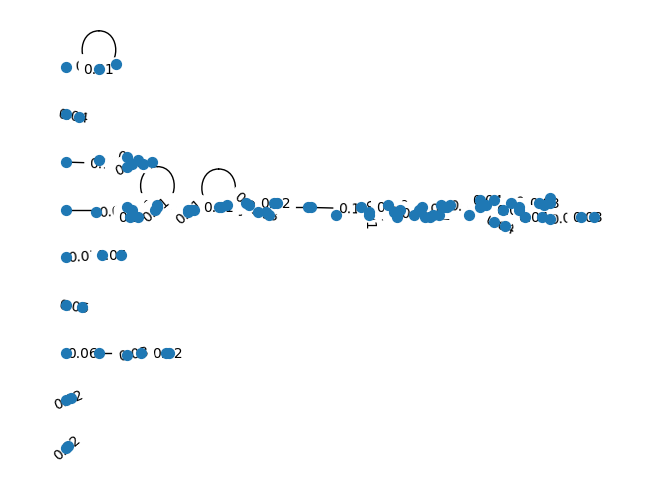

In [52]:
# Run the simulation and get the vessel network graph
G, A = run_simulation()

# Optionally, visualize the graph
pos = nx.get_node_attributes(G, 'pos')
edge_lengths = nx.get_edge_attributes(G, 'length')
nx.draw(G, pos, with_labels=False, node_size=50)
labels = {edge: f"{length:.2f}" for edge, length in edge_lengths.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


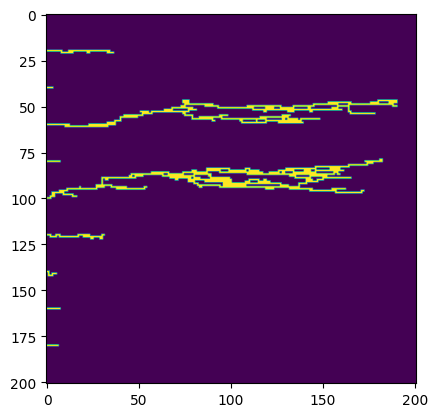

In [49]:
plt.imshow(A.N.T)